# Advanced Statistics for Quantitative Trading
<div class="alert alert-info"><strong>Part II : Time Series Modeling with Python</strong></div>

#### Notebook Created on: 6 July 2020
##### Last Update: 6 Jan 2023
##### Version 4.5
##### Author: Vivek Krishnamoorthy

## **Agenda for today**

- Modeling time series using decomposition
    - A fleeting exploration of oil price seasonality
    - Using the `statsmodels` library for decomposition
- A closer look at ACF and PACF
- Testing for stationarity
- Modeling time series using
    - AR
    - MA
    - ARIMA
- Modeling and forecasting volatility using ARCH/GARCH

<a id = 'convert'></a>

### Anatomy of a time series process

Time series processes have a wide variety of patterns. So it is helpful to consider them as a combination of *systematic* and *unsystematic* components.

- **Systematic**: These are recurring in nature and so can be described and modeled.
- **Non-systematic**: These are random in nature and so cannot be directly modeled.

The systematic components can be further split into *level*, *trend*, and *seasonality* whereas the non-systematic component is referred to as *noise*.

- **Level**: The average value of the process.
- **Trend**: The direction and rate of change of the process. The slope is a good proxy for it.
- **Seasonality**: Deviations in the process caused by recurring short-term cycles.
- **Noise**: The random variation observed in the process.

Another useful abstraction while analyzing time series processes is to see them as either an *additive* or a *multiplicative* blend of the four constituent parts mentioned.

**Additive model**: The process $X(t)$ has the form
$$X(t) = Level + Trend + Seasonality + Noise$$

We use an additive model when the underlying process under examination has the following characteristics.
- The process changes remain constant over time (i.e. they are linear). So the trend line would be straight.
- It shows linear seasonality. That is to say the frequency and amplitude (i.e. the width and the height) of the cycles remain constant over time.



**Multiplicative model**: The process $X(t)$ has the form
$$X(t) = Level \times Trend \times Seasonality \times Noise$$

We use a multiplicative model when the underlying process under examination has the following characteristics.
- The process changes vary over time (i.e. they are non-linear in nature).
- An exponential or quadratic or higher order polynomial process is multiplicative. So the trend-line would be curved, not straight. 
- It shows non-linear seasonality. That is to say the frequency and amplitude (i.e. the width and the height) of the cycles vary over time.

In the (harsh) real world, we often encounter non-linear or even mixed processes and therefore have to work with the multiplicative model as our prototype. But we prefer to work with linear processes as they are easier to use. So we transform the original process into a linear one. A commonly used trick is applying a log transformation.

### Modelling a time series using decomposition

There are several available libraries (ex. [`statsmodels`](https://www.statsmodels.org/stable/tsa.html), [`prophet`](https://facebook.github.io/prophet/docs/quick_start.html), [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), [`PyFlux`](https://pyflux.readthedocs.io/en/latest/), [`fecon236`](https://github.com/MathSci/fecon236), [`PM-Prophet`](https://github.com/luke14free/pm-prophet) at the time of this writing) in Python to develop sophisticated time series models for forecasting. 

We work with `statsmodels`. Both offer convenient routines to automatically decompose a time series into their fundamental components.

To illustrate the ideas, we make use of the daily historical prices of crude oil (from 2003 to 2022) and soybean (from 2000 to 2020).

> *The OPEC Reference Basket (ORB), also referred to as the OPEC (Organization of Petroleum Exporting Countries ex. Qatar, Saudi Arabia, Iran, Iraq) Basket, is a weighted average of prices for petroleum blends produced by OPEC members. It is used as an important benchmark for crude oil prices. The OPEC Basket, including a mix of light and heavy crude oil products, is heavier than both Brent crude oil, and West Texas Intermediate crude oil.* - [Source](https://www.investopedia.com/terms/o/opecbasket.asp)

> *The soya bean is a species of legume and is one of the world’s most important oil plants, since around half of vegetable oil produced is obtained from the soya bean. It is particularly significant because of its protein content (39 per cent) and its oil content (17 per cent), since no other plant offers comparable values. Soya is also used as an ingredient and additive in the food industry. It is estimated that around 30,000 foods contain ingredients derived from soya. Soya milk can be produced from ground yellow soya beans, and then can be processed into tofu. Tofu is used as a meat substitute in vegetarian cookery because of its high protein content and because it contains all the essential amino acids.* - [Source](https://markets.businessinsider.com/commodities/soybeans-price/usd)







We try the `seasonal_decompose` method from the `statsmodels.tsa` sub-library.

### Seasonal decomposition using the `seasonal_decompose` routine in `statsmodels` 

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import nasdaqdatalink

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

In [2]:
end4 = datetime.date(2022, 12, 31)
start4 = datetime.date(2003, 1, 1)

ticker4 = "OPEC/ORB"

In [3]:
## ***********************************************************
## ***** EXPERIMENTAL : IGNORE THIS CELL *********************
## Trials with other commodity data
## ***********************************************************

# "OPEC/ORB" this is crude oil prices per barrel
# WGC/GOLD_DAILY_INR for daily gold prices in India available until 10 March 2020
# TFGRAIN/SOYBEANS for daily soy bean prices per bushel
# WORLDAL/PALPROD primary aluminium production across continents. not tried.

In [4]:
df = nasdaqdatalink.get(dataset=ticker4, start_date=start4, end_date=end4)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker4} data")

Downloaded 5160 rows and 1 columns of OPEC/ORB data


In [5]:
df4 = df.copy()

In [6]:
print(df4.head(10))
print(df4.tail())

            Value
Date             
2003-01-02  30.05
2003-01-03  30.83
2003-01-06  30.71
2003-01-07  29.72
2003-01-08  28.86
2003-01-09  29.51
2003-01-10  29.82
2003-01-13  29.82
2003-01-14  30.21
2003-01-15  30.66
            Value
Date             
2022-12-23  80.58
2022-12-27  82.23
2022-12-28  81.96
2022-12-29  80.39
2022-12-30  81.29


In [7]:
df4.rename(columns={'Value': 'price'}, inplace=True)

In [8]:
oil_long_run_mean = np.round(df4['price'].mean(), 1)
print(oil_long_run_mean)

69.2


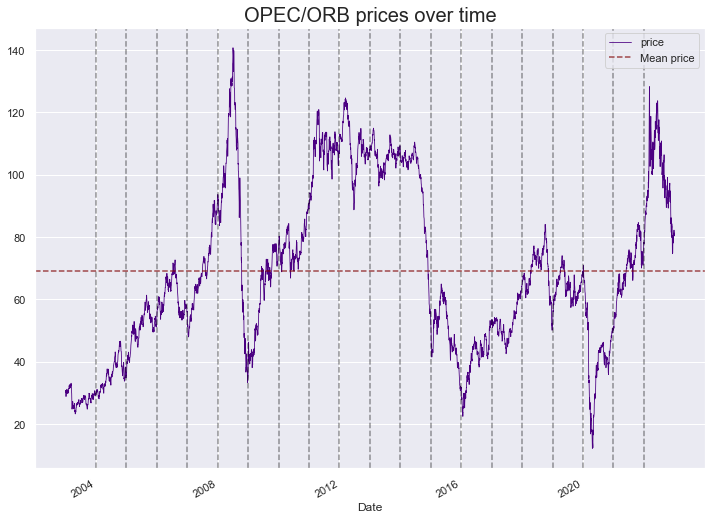

In [9]:
df4.plot(figsize=(12, 9), linewidth=0.8, color='indigo')
plt.title(f"{ticker4} prices over time", fontsize=20)
for eachyear in range(start4.year, end4.year):
    plt.axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)

plt.axhline(df4['price'].mean(), label='Mean price', color='maroon', linestyle='--', alpha=0.7)
plt.legend()

Points to note:
- There are upward and downward trends in the prices. Looks linear. Needs further probing.
- There seems to be seasonality and we can investigate further by looking at some moving averages.

In [10]:
window_length = 21 # for 1 monthly moving average calculations
window_length2 = 252 # for annual moving average calculations

## Calculating 21-day rolling mean and volatility

df4['rolling_21d_mean'] = df4['price'].rolling(window=window_length).mean()
df4['rolling_21d_vol'] = df4['price'].rolling(window=window_length).std()


## Calculating 252-day rolling mean and volatility

df4['rolling_12m_mean'] = df4['price'].rolling(window=window_length2).mean()
df4['rolling_12m_vol'] = df4['price'].rolling(window=window_length2).std()

Text(0, 0.5, 'Price per barrel (in US$)')

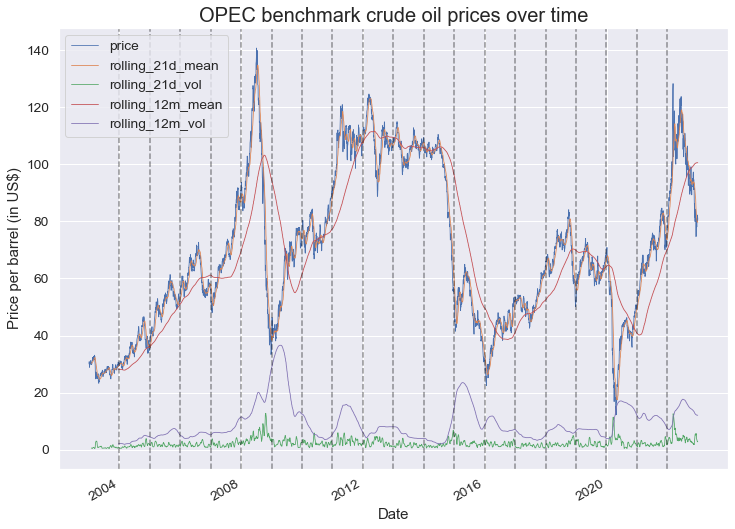

In [11]:
sns.set(font_scale=1.25)
df4.plot(figsize=(12, 9), linewidth=0.8)

for eachyear in range(start4.year, end4.year):
    plt.axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)


plt.title("OPEC benchmark crude oil prices over time", fontsize=20)
plt.xlabel("Date")
plt.ylabel("Price per barrel (in US$)")

Points to note:
- The yearly moving average of the prices show a linear trend (which changes roughly every couple of years).
- The monthly moving price average shows seasonality.
- The rolling volatility is time-varying in both (monthly and annual) cases.
- Let's try using the **multiplicative** model.

### _Enter rabbit hole: A fleeting exploration of oil price seasonality_

In [12]:
df4x = df.copy()

In [13]:
df4x.head()

,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


In [14]:
df4x = df4x.resample("M").mean()

In [15]:
df4x.rename(columns={'Value': 'monthly_mean_price'}, inplace=True)

In [16]:
df4x['year'] = df4x.index.year

In [17]:
df4x['month'] = df4x.index.month_name().str[:3]

In [18]:
df4x.tail()

,monthly_mean_price,year,month
Date,,,
2022-08-31,101.898696,2022,Aug
2022-09-30,95.317727,2022,Sep
2022-10-31,93.621429,2022,Oct
2022-11-30,89.731818,2022,Nov
2022-12-31,79.681905,2022,Dec


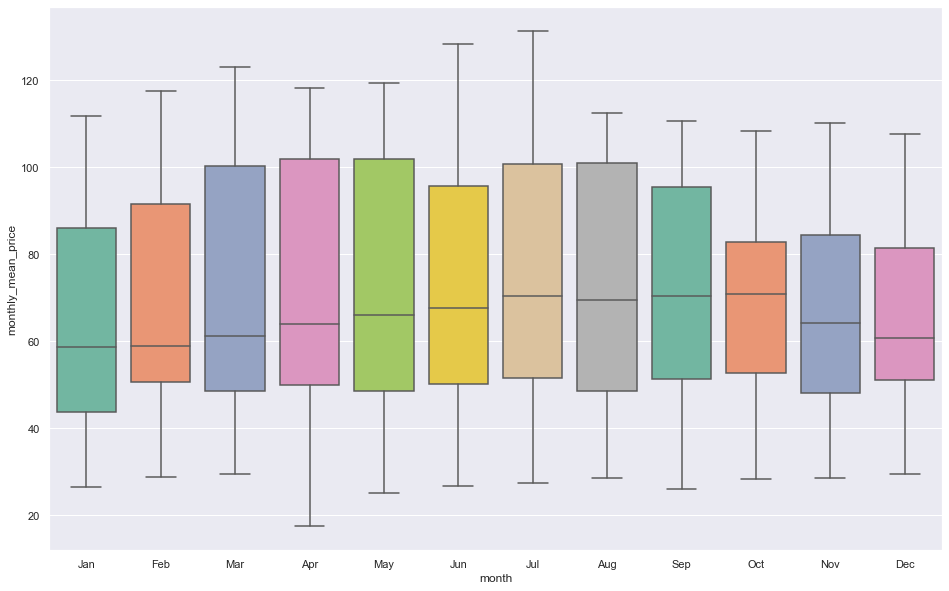

In [19]:
# define figure size with width = 16 and height = 10

sns.set(rc={"figure.figsize":(16, 10)})

# box plot grouping by month to check for trend changes monthly

df4xbox = sns.boxplot(x='month', y='monthly_mean_price', data=df4x, 
                   order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                   palette='Set2')

Observations:

- There appears to be an increasing trend in mean price per barrel from January to July followed by a decrease in mean price from August to December.
- The inter quantile range (IQR) is the lowest in the last three months of the year and coincides with the holiday season in many parts of the world.


### _Exit rabbit hole: A fleeting exploration of oil price seasonality_

### Continuing with using `statsmodels`

I now use the multiplicative decomposition model to extract seasonality observed in the ORB prices. I use the `seasonal_decompose` routine with `period=252`. That is to say, the trend repeats every 252 days (# of trading days in each calendar year).

In [20]:
decompose_series = seasonal_decompose(df4['price'], period=252, model="multiplicative")

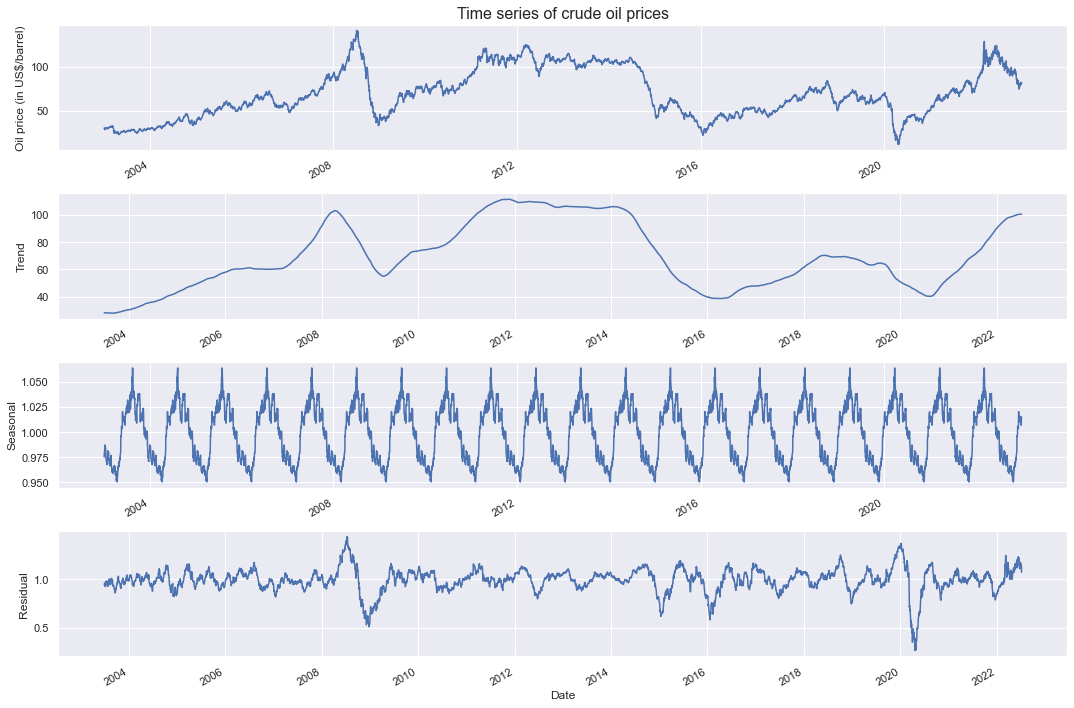

In [21]:
fig, ax = plt.subplots(4, 1, figsize=(15, 10))

decompose_series.observed.plot(ax=ax[0])
ax[0].set_title("Time series of crude oil prices", fontsize=16)
ax[0].set(xlabel="", ylabel="Oil price (in US$/barrel)")


decompose_series.trend.plot(ax=ax[1])
ax[1].set(xlabel="", ylabel="Trend")


decompose_series.seasonal.plot(ax=ax[2])
ax[2].set(xlabel="", ylabel="Seasonal")


decompose_series.resid.plot(ax=ax[3])
ax[3].set(xlabel="Date", ylabel="Residual")


plt.tight_layout()

In [22]:
decompose_series.seasonal

Date
2003-01-02    0.975299
2003-01-03    0.979322
2003-01-06    0.982455
2003-01-07    0.982527
2003-01-08    0.987101
                ...   
2022-12-23    1.010945
2022-12-27    1.006803
2022-12-28    1.007030
2022-12-29    1.015077
2022-12-30    1.014851
Name: seasonal, Length: 5160, dtype: float64

Observations:

- The plot shows us the observed, trend, seasonal and residual time series. We can access each component by typing: `decompose_series.trend`, `decompose_series.seasonal`, and `decompose_series.residual` 
- The trend plot shows an increasing trend until 2008 and then a decreasing trend until 2009, followed by some ups, plateaus and downs until 2022.
- The seasonal plots shows a repeating trend every year.
- The residual plot clearly has non-constant volatility. If the model was a suitable fit, then after taking out the trend and seasonality present in the price data, we would have residuals that do not have any discernable pattern. Not so here.
- At this stage, we would evaluate alternatives to model the residuals. We could even consider exogenous variables like oil production, renewable energy investments, etc. which would influence oil prices (outside the scope of this session).
- From the `statsmodels` documentation: *This is a naive decomposition. More sophisticated methods should be preferred.*

Let's now inspect a two year period (I pick the years 2015 and 2016) closely.

In [23]:
df4.tail()

,price,rolling_21d_mean,rolling_21d_vol,rolling_12m_mean,rolling_12m_vol
Date,,,,,
2022-12-23,80.58,79.891905,2.984858,100.547976,12.092549
2022-12-27,82.23,79.817143,2.900548,100.557143,12.077716
2022-12-28,81.96,79.913810,2.938082,100.562341,12.069393
2022-12-29,80.39,79.769524,2.829688,100.555952,12.079680
2022-12-30,81.29,79.681905,2.747731,100.554722,12.081633


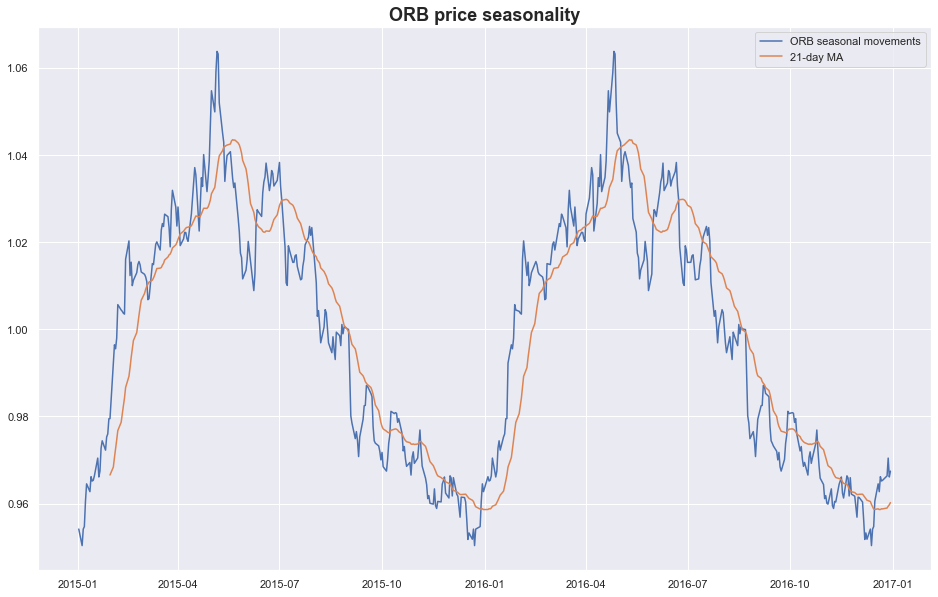

In [24]:
oil_price_seasonality = decompose_series.seasonal[df4.index.year.isin([2015, 2016])]
ma_oil_price = oil_price_seasonality.rolling(window=21).mean()
plt.plot(oil_price_seasonality, label='ORB seasonal movements')
plt.plot(ma_oil_price, label='21-day MA')
plt.title("ORB price seasonality", fontsize=18, fontweight='bold')
plt.legend()
plt.show()

### A closer look at ACF and PACF

Consider a supermarket near your home which has deep discounts on staples (rice, flour, sugar, potatoes) on Tuesdays, Thursdays and Saturdays each week.
The price of staples on Monday will directly influence their prices on Wednesday, the prices on Tuesday will directly affect their prices on Thursday and so on.

So we can calculate this influence (of 2-day old prices and the present day's prices) using the well known idea of correlation. How?

We line up 2-day old prices in a column and the present day's prices in another column. 
We then compute the correlations of these two columns of numbers. That's it!

We call this auto-correlation or serial correlation. 'Auto' here means 'self'. Since we're computing the correlation of a variable with itself (i.e. a past version of itself).

Mathematically, we can write this as $Corr(S_t, S_{t-2})$.\
This is also called the ACF at lag 2.

As we see, calculating the autocorrelation is quite straightforward. 
It's Pearson's correlation.

When we look at the influences on say, Wednesday's prices, there are mainly two effects in operation
- Monday prices will influence Tuesday prices which influence Wednesday's prices. i.e. the indirect effect of Monday's prices via Tuesday's prices are seen on Wednesday's prices.
- Monday's prices directly influence Wednesday's prices

![Image](acf_pacf_2.jpg)

The PACF helps us in capturing ONLY the direct effect of Monday's prices on Wednesday's prices.\
It does so via multiple regression where $S_t = \phi_{21}S_{t-1} + \phi_{22}S_{t-2} + \epsilon_t$\
Here $\phi_{22}$ will be the PACF at lag 2.

Fortunately, we don't need to delve into the thorny math and modeling to compute PACF or ACF at different lags. There are many statistical libraries like `statsmodels` which do it with a single line of code.

#### In summary,

- The PACF at lag $k$, is the **direct** correlation between the value of something today and its value $k$ periods back i.e. it removes the indirect effects that occur via shorter lags $k-1, k-2, k-3,..., 1$
- The ACF at lag $k$, is the correlation **(direct + indirect)** between the value of something today and its value $k$ periods back.



### Checking for stationarity

There are three ways of checking for stationarity in a time series.
1. Visual inspection
2. Statistical tests
3. ACF/PACF plots

We prefer working with stationary time series processes because it makes modeling, analysis and forecasting more feasible.

For this section, we work with the last 25 years of daily gold prices in India. The prices shown are denominated in INR per ounce.

> *Gold is a liquid asset, ranking at levels comparable to many global stock markets as well as currency spreads. Its liquidity is often sourced during periods of stress in the markets, one of its appealing qualities.* - [Source](https://www.gold.org/goldhub/data/trading-volumes)


In [25]:
start6 = '1995-01-01'
end6 = '2021-09-29'
ticker6 = "WGC/GOLD_DAILY_INR"

In [26]:
df = nasdaqdatalink.get(dataset=ticker6, start_date=start6, end_date=end6)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker6} data")

Downloaded 6575 rows and 1 columns of WGC/GOLD_DAILY_INR data


In [27]:
#############################################################################
################# PLEASE USE BELOW STATEMENTS IF NEEDED #####################
#############################################################################

## If you have don't have quandl, you can read the csv file as shown.

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df.to_csv("gold_prices_inr.csv")
# df4 = pd.read_csv("gold_prices_inr.csv", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [28]:
df.head()

,Value
Date,
1995-01-02,12022.09
1995-01-03,11948.83
1995-01-04,11781.62
1995-01-05,11771.27
1995-01-06,11769.08


In [29]:
df.tail()

,Value
Date,
2020-03-09,123911.33
2020-03-10,122666.66
2020-03-11,121778.01
2020-03-12,116573.42
2020-03-13,115510.47


In [30]:
df6 = df.copy()

In [31]:
df6.rename(columns={"Value": "price"}, inplace=True)

In [32]:
df6.tail()

,price
Date,
2020-03-09,123911.33
2020-03-10,122666.66
2020-03-11,121778.01
2020-03-12,116573.42
2020-03-13,115510.47


In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sms
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

In [34]:
def check_stationarity(y, wl1=21, wl2=252, lags=40, figsize=(18, 12)):
    """ Checks the stationarity of a pandas Series (default is daily prices or returns),
        using plots, correlograms and the ADF test
    """
    ## Calculating rolling statistics
    
    rolling_wl1_mean = y.rolling(window=wl1).mean()
    rolling_wl2_mean = y.rolling(window=wl2).mean()
    rolling_wl1_vol = y.rolling(window=wl1).std()
    rolling_wl2_vol = y.rolling(window=wl2).std()
    
    ## Plotting the price, rolling statistics and correlograms
    
    fig = plt.figure(figsize=(18, 14))
    sns.set(font_scale=1)
    layout = (2, 2)
    y_ax = plt.subplot2grid(layout, (0, 0))
    vol_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    y.plot(ax=y_ax)
    rolling_wl1_mean.plot(ax=y_ax)
    rolling_wl2_mean.plot(ax=y_ax)
    
    rolling_wl1_vol.plot(ax=vol_ax)
    rolling_wl2_vol.plot(ax=vol_ax)
    y_ax.set_title('Rolling means over time')
    y_ax.legend(['observed', f'{wl1}-period MA of observed', f'{wl2}-period MA of observed'], loc='best')
    #y_ax.set_ylabel("Gold prices(in INR)/oz.")
    
    vol_ax.set_title('Rolling volatility over time')
    vol_ax.legend([f'{wl1}-period MA of volatility', f'{wl2}-period MA of volatility'], loc='best')
    
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
    
    ## Running the Augmented Dickey-Fuller test
    print('--------------------------------------------------------------')
    print('--------- The augmented Dickey-Fuller test results -----------')
    print('--------------------------------------------------------------')
    adftest = adfuller(y, autolag='AIC')
    results = pd.Series(adftest[0:4], index=['Test Statistic','p-value','# of Lags','# of Observations'])
    for key,value in adftest[4].items():
        results[f'Critical Value ({key})'] = '{0:.3f}'.format(value)
    print(results)
    print('--------------------------------------------------------------')

In [35]:
check_stationarity?

Signature: check_stationarity(y, wl1=21, wl2=252, lags=40, figsize=(18, 12))
Docstring:
Checks the stationarity of a pandas Series (default is daily prices or returns),
using plots, correlograms and the ADF test
File:      c:\users\rajpu\appdata\local\temp\ipykernel_4712\2742863286.py
Type:      function


--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic          1.054921
p-value                 0.994813
# of Lags                   32.0
# of Observations         6542.0
Critical Value (1%)       -3.431
Critical Value (5%)       -2.862
Critical Value (10%)      -2.567
dtype: object
--------------------------------------------------------------


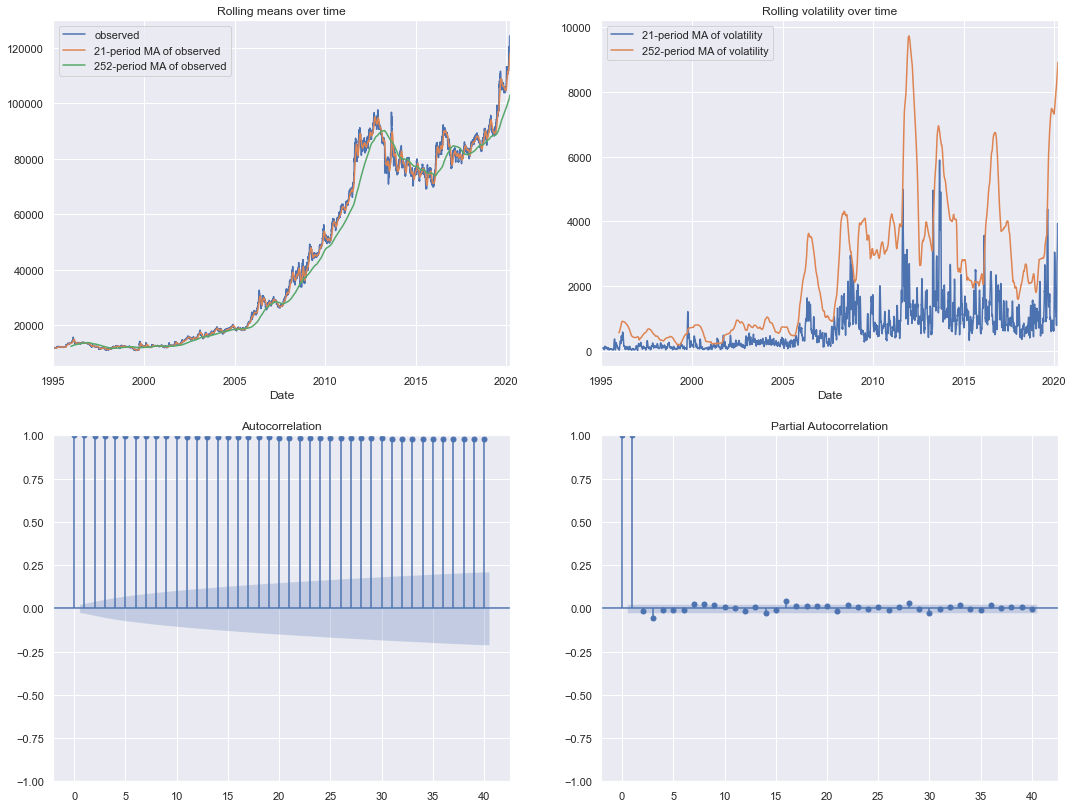

In [36]:
check_stationarity(df6['price'])

Points to note:
- In the ADF test, if the test statistic is greater than the critical value, we conclude that the series is non-stationary. We can draw the same conclusion by examining the p-value. A p-value greater than our significance level (conventionally 5%) means we cannot reject our null hypothesis (The series is not stationary). 
- For the gold prices, we have a p-value of nearly 1 (and equivalently the test statistic is greater than the critical values at all 3 significance levels), so we conclude that the price series is not stationary.
- The rolling means and volatility plots are time-varying. So we also conclude visually that gold prices in India are non-stationary.
- From the ACF, there are significant autocorrelations above the 95% confidence interval at all lags. From the PACF, we have significance in autocorrelations at lags 1, 2, 3, 6, and 8.

In [37]:
df6['log_returns'] = np.log(df6['price'] / df6['price'].shift(1))
df6.dropna(axis='rows', how='any', inplace=True)

--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic         -17.500127
p-value                       0.0
# of Lags                    26.0
# of Observations          6547.0
Critical Value (1%)        -3.431
Critical Value (5%)        -2.862
Critical Value (10%)       -2.567
dtype: object
--------------------------------------------------------------


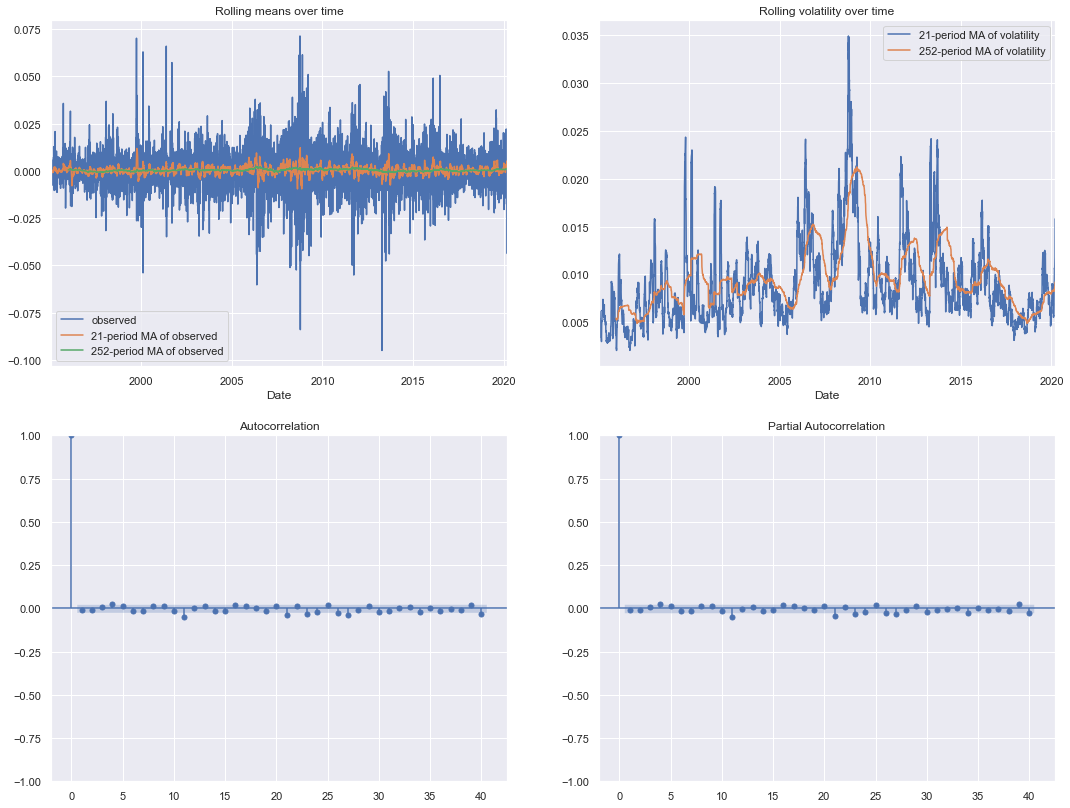

In [ ]:
check_stationarity(df6['log_returns'])

Points to note:
- As per the ADF test results, the returns of gold are stationary since the p-value is almost 0 and the test statistic is less than all the critical values.
- The returns and rolling means of the returns are all centred around 0. As the time scale increases, the means become more and more constant. At shorter time scales, the noise tends to obscure the signal.
- The volatily is time-varying at both the faster and slower rolling levels.
- There are little spikes in the ACF plot at lags 3, 11, and 21.

### Method III : Modeling time series using ARIMA models

The **ARIMA (AutoRegressive Integrated Moving Average)** class of models is a popular statistical technique in time series forecasting. It exploits different standard temporal structures seen in time series processes.

> *Exponential smoothing and ARIMA models are the two most widely used approaches to time series forecasting, and provide complementary approaches to the problem. While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.* - [Source](#hyndman)

##### ***Crash course on ARIMA***
We will now take a brief look at its key features by taking apart the acronym.

1. **Auto Regressive (AR)**:

- Regression of a time series process onto itself (its past versions)
- A time series process is $AR$ if its present value depends on a linear combination of past observations.
- In financial time series, an $AR$ model attempts to explain the mean reversion and trending behaviours that we observe in asset prices.

2. **Integrated (I)**:

For a time series process ${X_t}$ recorded at regular intervals, the difference operation is defined as $$\nabla X_t = X_t - X_{t-1}$$

The difference operator (denoted by $\nabla$) can be applied repeatedly. For example, 
$$\nabla^2 X_t = \nabla X_t - \nabla X_{t-1}$$

- A time series process is integrated of order $d$ (denoted by $I(d)$), if differencing the observations $d$ times, makes the process stationary.

3. **Moving Average (MA)**:

-  A time series process is $MA$ if its present value can be written as a linear combination of past error terms.
- $MA$ models try to capture the idiosyncratic shocks observed in financial markets. We can think of events like terrorist attacks, earnings surprises, sudden political changes, etc. as the random shocks affecting the asset price movements.

When we use the ARIMA class to model a time series process, each of the above components are specified in the model as parameters (with the notations $p$, $d$, and $q$ respectively). 

That is, the classification $ARIMA(p, d, q)$ process can be thought of as $$AR(p)I(d)MA(q)$$ 
Here,

1. $p$: The number of past observations (we usually call them *lagged terms*) of the process included in the model.
2. $d$: The number of times we difference the original process to make it stationary.
3. $q$: The number of past error terms (we usually call them *lagged error terms* or *lagged residuals*) of the process included in the model.

When we model our time series process with the ARIMA class, we implicitly assume that the underlying data generating process (and by extension the observations we record) is an ARIMA process. 

We should validate our assumptions (especially the implicit ones which slip under the radar) and recognize the limitations of our models. A well-known deficiency of ARIMA applications on financial time series is its failure to capture the phenomenon of volatility clustering. However, despite their inaccurate point estimates, they give rise to informative confidence intervals.

 **All of the below models would have good explanatory and predictive power only if the process is stationary.**

$$AR(1) : x_t = \phi x_{t-1} + \epsilon_t$$
$$MA(1) : x_t = \epsilon_t + \theta \epsilon_{t-1}$$

$$AR(p) : x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + \dots + \phi_p x_{t-p} + \epsilon_t$$
$$MA(q) : x_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_q$$

$$ARMA(p, q) : x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + \dots + \phi_p x_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_q$$

### Autoregressive models

Etymologically, autoregressive = auto (self) + regressive

As we know, regression is the method by which we try to predict something based on other things.
In autoregression, we try to predict something based on the past values of that same thing.

The something I refer to above, could be the price of some variable we're interested in, the weight of an object, the quantity of a commodity consumed, etc.

Let's start with an autoregressive model of order 1, denoted as $AR(1)$.

$$AR(1): S_t = \phi_0 + \phi_1 S_{t-1} + \epsilon_t$$

Here,
- $S_t$: Value of the variable $S$ at time $t$
- $S_{t-1}$: Value of the variable $S$ at time $t-1$
- $\phi_0$: the intercept
- $\phi_1$: the parameter/slope we want to estimate
- $\epsilon_t$: the error/residual at time $t$

Some parts of the material below, I directly use from the **Quantra** course on *Financial Time Series Analysis*.


#### Forecasting prices using the $AR(1)$ model

We now train the AR(1) model using the ARMA/ARIMA method from the `statsmodels` library.

The ARMA/ARIMA method can be imported as below

```python
from statsmodels.tsa.arima_model import ARMA, ARIMA
```

Using the `ARMA` or `ARIMA` method, the autoregressive model can be trained as

```python
ARMA(data, (p, q)
```
or
```python

ARIMA(data, (p, d, q))
```

where

- p is the AR parameter, that needs to be defined or worked out.
- d is the difference parameter. This will be zero in case of AR models.
- q is the MA parameter. This will also be zero in case of an AR model.
Hence, the autoregressive model can be trained as

`ARIMA(data, (p, 0, 0))`
or
`ARMA(data, (p, 0))`


In [ ]:
import numpy as np
import pandas as pd

import time

import datetime
import matplotlib.pyplot as plt
#plt.style.use("seaborn-talk")
import yfinance as yf
import nasdaqdatalink


import scipy.stats as scs
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARMA, ARIMA

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

import warnings
warnings.filterwarnings("ignore")

In [ ]:
start1 = datetime.date(2011, 12, 25)
end1 = datetime.date(2022, 12, 31)
ticker1 = "NFLX"

In [ ]:
df = yf.download(ticker1, start=start1, end=end1)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker1} data")

[*********************100%***********************]  1 of 1 completed
Downloaded 2772 rows and 6 columns of NFLX data


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-12-27,10.328571,10.355714,10.028571,10.085714,10.085714,21940800
2011-12-28,10.074286,10.142857,9.795714,9.885714,9.885714,23597000
2011-12-29,9.854286,9.984286,9.658571,9.900000,9.900000,26163200
2011-12-30,9.872857,10.084286,9.832857,9.898571,9.898571,21809200
2012-01-03,10.040000,10.388571,10.018571,10.320000,10.320000,29213800


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-23,296.179993,298.459991,291.910004,294.959991,294.959991,4251100
2022-12-27,293.190002,293.570007,282.130005,284.170013,284.170013,5778100
2022-12-28,281.920013,285.190002,273.410004,276.880005,276.880005,5964400
2022-12-29,283.179993,295.500000,281.010010,291.119995,291.119995,9588500
2022-12-30,285.529999,295.010010,283.220001,294.880005,294.880005,7557400


In [ ]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df1 = df.copy()

In [ ]:
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month
## 'Close' and 'Adj Close': last closing price of the month

df1 = df1.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 
                             'Close':'last', 'Adj Close':'last'})

In [ ]:
df1.tail()

,Open,High,Low,Close,Adj Close
Date,,,,,
2022-12-04,284.000000,321.989990,275.940002,320.410004,320.410004
2022-12-11,316.459991,329.000000,302.100006,320.010010,320.010010
2022-12-18,320.000000,332.720001,286.549988,290.709991,290.709991
2022-12-25,289.730011,300.660004,280.809998,294.959991,294.959991
2023-01-01,293.190002,295.500000,273.410004,294.880005,294.880005


In [ ]:
df1.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df1.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)

In [ ]:
df1.shape

(575, 1)

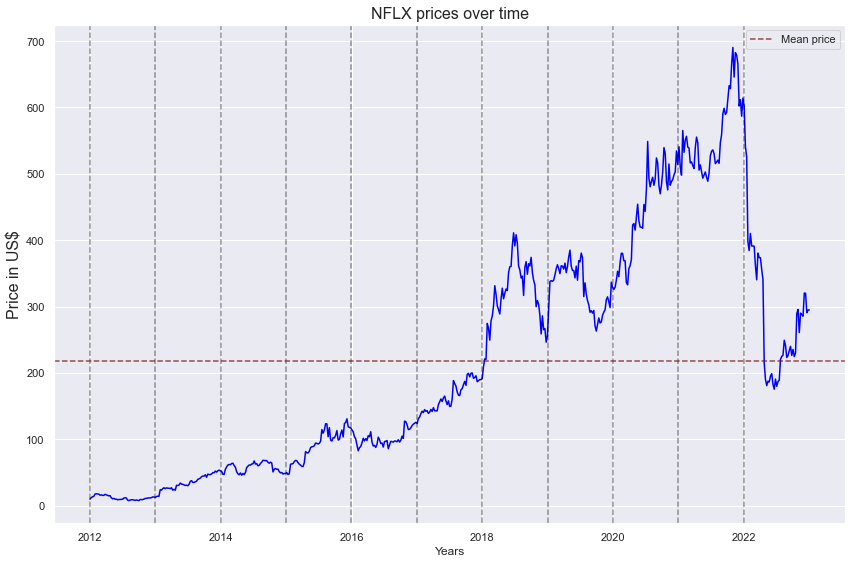

In [ ]:
# Plot the series
plt.figure(figsize=(12, 8))
plt.plot(df1['adj_close'], color='blue')
plt.title(f"{ticker1} prices over time", fontsize=16)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Price in US$", fontsize=16)
plt.tight_layout()


for eachyear in range(start1.year, end1.year):
    plt.axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)

plt.axhline(df1['adj_close'].mean(), label='Mean price', color='maroon', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

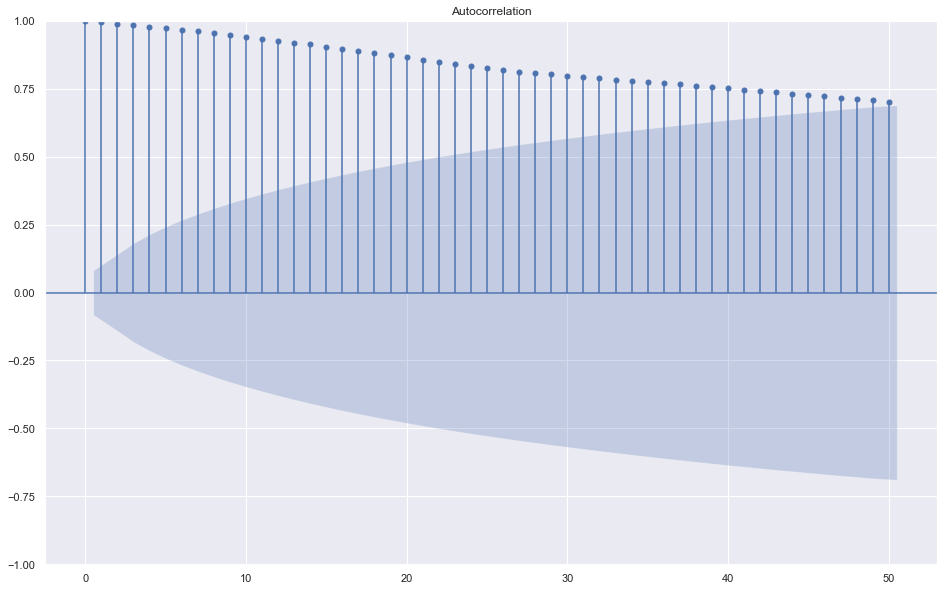

In [ ]:
sm.graphics.tsa.plot_acf(df1['adj_close'], lags=50, alpha=0.05);

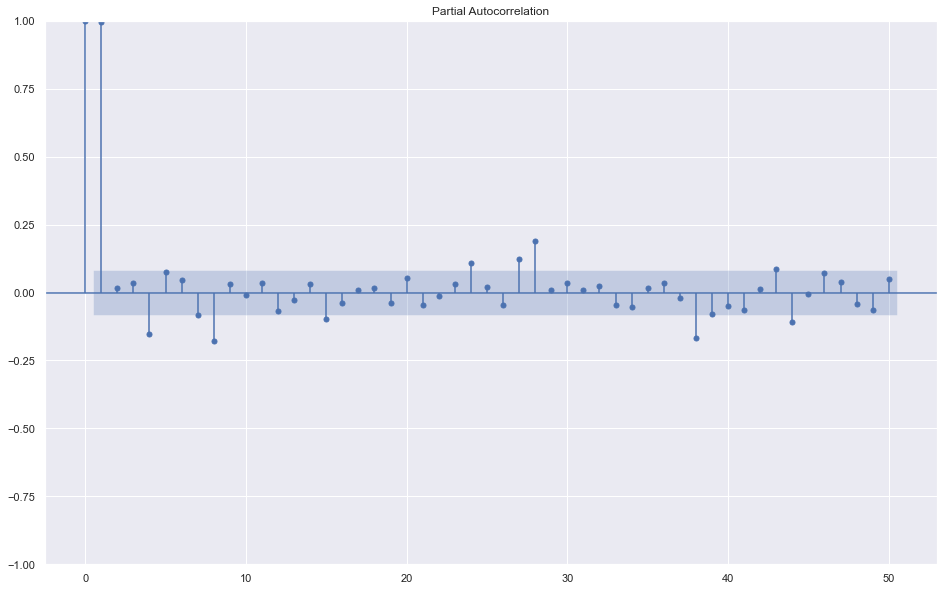

In [ ]:
sm.graphics.tsa.plot_pacf(df1['adj_close'], lags=50, alpha=0.05);

Based on PACF, and to keep things simple, let's start with an AR(1) model to fit the data

In [ ]:
df1.tail()

,adj_close
Date,
2022-12-04,320.410004
2022-12-11,320.010010
2022-12-18,290.709991
2022-12-25,294.959991
2023-01-01,294.880005


In [ ]:
## Set the train and test data

train_end = datetime.date(2021, 7, 2)
test_end = end1

df1_train = df1[:train_end]
df1_test = df1[train_end + pd.Timedelta(days=1): test_end]

In [ ]:
df1.shape, df1_train.shape, df1_test.shape

((575, 1), (496, 1), (78, 1))

In [ ]:
## Instantiate/define the model

model1a = ARMA(df1_train['adj_close'], order=(1, 0))

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [ ]:
## Fit the model
starting = time.time()
model1a_fit = model1a.fit(disp=0)
ending = time.time()
print(f"Time taken to fit the model:{round(ending-starting, 2)} seconds")

In [ ]:
# Model summary

print(model1a_fit.summary())

### Predicted model:

From the output above, we see that

$\phi_0 = 245.79$, and $\phi_1 = 0.99$

So the model works out to \
$\hat{S_t} = 245.79 + 0.99 S_{t-1}$

In [ ]:
predict_start = df1_test.index[0]
predict_end = df1_test.index[-1]

In [ ]:
# Predict the output in the test set
starting = time.time()
predicted_values = model1a_fit.predict(start= predict_start, end = predict_end)
residual_values = df1_test['adj_close'] - predicted_values
ending = time.time()

print(f"Time taken to forecast out-of-sample: {round(ending-starting, 2)} seconds")

In [ ]:
# Plot the residuals

plt.figure(figsize=(12, 8))
plt.plot(residual_values)
plt.title(f"Residuals from the AR(1) model", fontsize=16)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Errors", fontsize=16)
plt.tight_layout()

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)


plt.axhline(0, label='Zero error', color = 'purple', linestyle='--', alpha=0.7)
plt.axhline(residual_values.mean(), label='Mean error', color='maroon', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
# Plot the predicted v/s the actual values

plt.figure(figsize=(12, 8))
plt.plot(df1_test['adj_close'])
plt.plot(predicted_values)
plt.title(f"Predicted v/s actuals from the AR(1) model", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Prices", fontsize=16)

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)
    
plt.legend(('Actual', 'Predicted'), fontsize=16 )
plt.tight_layout()

In [ ]:
print("Mean absolute percent error:", round(np.mean(abs(residual_values/df1_test['adj_close'])), 3))
print("Root mean squared error:", round(np.sqrt(np.mean(residual_values**2)), 3))

Considering the plots, and the errors we've encountered, the above approach is not a great way to go about it.

### What's the alternative then?

#### Answer: Rolling forecasts

Many machine learning models are not time-indexed. The conventional approach of train-test split (80:20, 90:10, etc.) is quite a good way to build and use them for forecasts. But with time series, if we try to forecast the final 20% based on the initial 80%, we'll probably do alright for the first few predictions. However, as we make further forecasts, we rely on previous forecasts to make the next one. So the further we predict, the worse they tend to be.

In order to take advantage of the temporal structure of our data, we can instead predict one or two time periods ahead. We then update our models after each time period to forecast the next one or two time periods. That is, we create rolling forecasts, which, although computationally intensive, are better than the earlier approach.

In [ ]:
## Instantiate/define the model

model1b = ARMA(df1_train['adj_close'], order=(1, 0))

## Fit the model
starting = time.time()
model1b_fit = model1b.fit(disp=0)
ending = time.time()
print(f"Time taken to fit the model: {round(ending-starting, 2)} seconds")

In [ ]:
# Function to predict the price of 1 period ahead
def predict_price_AR(train_data):
    # Define the model
    model = ARMA(train_data, order=(1, 0))

    # Fit the model
    model_fit = model.fit(disp=0)

    # Make the forecast
    forecast_results = model_fit.forecast()

    return forecast_results[0][0]

In [ ]:
rolling_window = df1_train.shape[0]

In [ ]:
starting = time.time()

# Predict the price using `predict_price_AR` function
df1['predicted_price'] = df1['adj_close'].rolling(rolling_window).apply(predict_price_AR)
# Shift the predicted price by 1 period
df1['predicted_price'] = df1['predicted_price'].shift(1)
df1['error'] = df1['adj_close'] - df1['predicted_price']
ending = time.time()
print(f"Time taken for the rolling forecasts: {round(ending-starting, 2)} seconds")

In [ ]:
# Plot the residuals

plt.figure(figsize=(12, 8))
plt.plot(df1['error'])
plt.title(f"Residuals from the AR(1) model", fontsize=16)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Errors", fontsize=16)
plt.tight_layout()

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)


plt.axhline(0, label='Zero error', color = 'purple', linestyle='--', alpha=0.7)
plt.axhline(df1['error'].mean(), label='Mean error', color='maroon', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
# Plot the predicted v/s the actual values

plt.figure(figsize=(12, 8))
plt.plot(df1_test['adj_close'])
plt.plot(df1['predicted_price'])
plt.title(f"Predicted v/s actuals from the AR(1) model", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Prices", fontsize=16)

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)
    
plt.legend(('Actual', 'Predicted'), fontsize=16 )
plt.tight_layout()

In [ ]:
print("Mean absolute percent error:", round(np.mean(abs(df1['error']/df1.loc[predict_start:, 'adj_close'])), 3))
print("Root mean squared error:", round(np.sqrt(np.mean(df1['error']**2)), 3))

In [ ]:
import matplotlib.dates as mdates

In [ ]:
# Import libraries
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

def model_performance(observed, predicted):

    
    """This function will print the Mean Absolute Error, Mean Squared Error,
    Root Mean Squared Error and Mean Absolute Percentage Error.
    This function will also display the residula plot and the ACF.
    """

    # Mean Absolute Error
    mae = mean_absolute_error(observed, predicted)
    print('The Mean Absolute Error is %.2f' % mae)

    # Mean Squared Error
    mse = mean_squared_error(observed, predicted)
    print('The Mean Squared Error is %.2f' % mse)

    # Root Mean Squared Error
    rmse = sqrt(mean_squared_error(observed, predicted))
    print('The Root Mean Squared Error is %.2f' % rmse)

    # Mean Absolute Percentage Error
    mape = 100 * ((observed-predicted)/observed).abs().mean()
    print('The Mean Absolute Percentage Error is %.2f' % mape)

    # Residuals
    residuals = observed - predicted
    labels = observed.index
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 11))
    
    # Plot residual
    observed.plot(ax=ax1, color='purple')
    predicted.plot(ax=ax1, color='green')
    ax1.set_ylabel('Price')
    ax1.set_title('Predicted Vs. Observed')
    
    # Plot residual
    ax2.fill_between(residuals.index, residuals.values, color='red')
    ax2.set_ylabel('Error')
    ax2.set_xlabel('Date')
    ax2.set_title('Residual')
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))
    _=plt.xticks(rotation=45)
    
    # Autocorrelation plot of residuals
    sm.graphics.tsa.plot_pacf(residuals, ax=ax3, color='blue')
    ax3.set_xlabel('Lags')
    ax3.set_ylabel('Partial Autocorrelation')
    ax3.set_title('Partial Autocorrelation of Residuals')

    plt.tight_layout()
    plt.show()

# Call `model_performance` to evaluate the performance of the model
model_performance(df1['adj_close'].iloc[rolling_window:],
                  df1['predicted_price'].iloc[rolling_window:])

### MA model of order q

In [ ]:
# Read the csv file using read_csv method of pandas
data = pd.read_csv("wheat_etf_price_2011_2020.csv", index_col=0)
data.index = pd.to_datetime(data.index)

# Drop the missing values
data = data.dropna()

# Rolling Window
rolling_window = int(len(data)*0.70)

<a id='optimise'></a> 
## Optimizing the order (q) of the MA model

<a id='lag-period'></a> 
## Find the lag period (q)
Let us find the optimal lag period or order for the given time series using the ACF plot.

In [ ]:
# For statistical analysis
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

# Import and filter warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_acf(data['Adj Close'], lags=20, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

From the above plot, you can see that the lag terms upto 10 is statistically significant. So we train the MA(10) model using `ARIMA` from the `statsmodels` library.

In [ ]:
# Train the moving average model of order 10
model_fit_0 = ARIMA(data['Adj Close'][:rolling_window], (0, 1, 10)).fit()
print(model_fit_0.params.round(2))

From the output above, you can see that the fitted model is
$$ MA(10) = y_t = -0.23 + \epsilon_t + 0.09*\epsilon_{t-1} + ~...~ + 0.22*y_{t-10}$$

In [ ]:
# Function to predict the price of 1 day
def predict_price_MA(train_data):
    # Define model
    model = ARIMA(train_data, order=(0, 1, 10))
    # Fit the model
    model_fit = model.fit(disp=0, start_params=model_fit_0.params)
    # Make forecast
    forecast_results = model_fit.forecast()
    return forecast_results[0][0]

In [ ]:
# This cell will predict the values of the series and it is possible it will take time to run.
starting = time.time()
# Predict the price using `predict_price_AR` function
data['predicted_price'] = data['Adj Close'].rolling(rolling_window).apply(
    predict_price_MA)
# Shift the predicted price by 1 period
data['predicted_price'] = data['predicted_price'].shift(1)
data.round(2).tail()

ending = time.time()

print(f"Time taken to forecast prices is {ending-starting} seconds.")

In [ ]:
# Call `model_performance` to evaluate the performance of the model
model_performance(data['Adj Close'].iloc[rolling_window:],
                  data['predicted_price'].iloc[rolling_window:])

From the first two plots, you can see that the residuals are more positive than negative. Hence the model made lower predictions in most cases. From the third plot, you can see that there is autocorrelation between the residuals with its 3rd and 8th lagged value.




### ARIMA models

We now fit an ARIMA model to the weekly stock prices (from mid-2010 to mid-2019) of Netflix and learn to evaluate it.

In [ ]:
start8 = datetime.date(2010, 6, 30)
end8 = datetime.date(2022, 7, 1)
ticker8 = "NFLX"

In [ ]:
df = yf.download(ticker8, start=start8, end=end8, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker8} data")

In [ ]:
df8 = df.copy()

In [ ]:
#############################################################################
################# PLEASE USE BELOW STATEMENTS IF NEEDED #####################
#############################################################################

## If you have don't have quandl, you can read the csv file as shown.

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df.to_csv(f"{ticker8}.csv")
# df4 = pd.read_csv("NFLX.csv", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df8 = df.copy()

In [ ]:
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month
## 'Close' and 'Adj Close': last closing price of the month

df8 = df8.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 
                             'Close':'last', 'Adj Close':'last'})

In [ ]:
df8.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df8.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df8.tail())

In [ ]:
## Checking for null values

df8[df8['adj_close'].isnull()]

In [ ]:
start8_str = (start8 + pd.Timedelta("5 days")).strftime("%B %Y")
end8_str = (end8 - pd.Timedelta("5 days")).strftime("%B %Y")

In [ ]:
sns.set(font_scale=1.2)
df8['adj_close'].plot(figsize=(12, 8), title=f"{ticker8} weekly adjusted close prices ({start8_str} - {end8_str})")

In [ ]:
check_stationarity?

In [ ]:
%%time

check_stationarity(df8['adj_close'], wl1=4, wl2=52)

Points to note:
- The p-value is nearly 1 (and equivalently the test statistic is greater than the critical values at all 3 significance levels). So the ADF test result is that the price series is non-stationary.
- The rolling means and volatility plots are time-varying. So we arrive at the same conclusion by examining the plots.
- From the ACF, there are significant autocorrelations above the 95% confidence interval at all lags. From the PACF, we have spikes at lags 1, 8, 9, 13, 18, 23 and 38.

In [ ]:
df8['log_returns'] = np.log(df8['adj_close'] / df8['adj_close'].shift(1))
df8.dropna(axis='rows', how='any', inplace=True)

In [ ]:
%%time

check_stationarity(df8['log_returns'], wl1=4, wl2=52)

Points to note:
- As per the ADF test results, the `Netflix` returns are stationary since the p-value is almost 0 and the test statistic is less than all the critical values.
- The returns and rolling means of the returns are all centred around 0. As the time scale increases, the means become more and more constant. At shorter time scales, the noise tends to obscure the signal.
- The volatily is time-varying at both the faster and slower rolling levels.
- We can see bristles near or beyond the blue shadow at lags 17 and 26 in the ACF plot and lags 12, 16, 17, 18 and 26 in the PACF plot.
- **Returns are log price differences. So we can also infer from the above two checks, that the price series is integrated with order $1.$**

In [ ]:
%%time
##########################################################
################ ARIMA model fitting #####################
##########################################################
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

## Creating the ARIMA model class
## We select the order arbitrarily (p and q)
## We inferred d from the results of `check_stationarity`

## Defining the model by providing the training set and providing the parameters p, d, q
arima_model = ARIMA(df8['adj_close'], order=(3, 1, 2))

## Fitting the model, disp=0 is to switch off verbose display
arima_fit1 = arima_model.fit(disp=0)

## Printing a summary of the model
arima_fit1.summary()

### Predicted model:

$\hat{y_t} = y_{t-1} + 0.25 - 0.29{y_{t-1}} - 0.946{y_{t-2}} + 0.055{y_{t-3}} + 0.29{\epsilon_{t-1}} + 0.29{\epsilon_{t-1}}$



Points to note:
- We chose an $ARIMA(3, 1, 2)$ model to fit the price series of `Netflix`. Equivalently, we could have fit an $ARIMA(3, 0, 2)$ to the returns instead. 
- The `summary()` method provides the results of the model fitting exercise on the **in-sample data set** (a.k.a. the training data).
- The most important part is the table at the centre which has the coefficient values, their 95% confidence intervals and their corresponding p-values.
- However, we also need to run model diagnostics by examining the residual errors closely. This will tell us if our model was a good fit to the underlying data.

In [ ]:
def arima_diagnostics(resids_, figsize=(15, 9), n_lags=40):
    '''
    Diagnoses the fit of an ARIMA model by examining its residuals.
    Returns a chart with with multiple plots
    '''
    # Creating placeholder subplots
    M = 2
    N = 2
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(M, N, figsize=figsize)

    r = resids_
    resids_ = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids_[~(np.isnan(resids_))]
    
    # Plotting residuals over time
    sns.lineplot(x=np.arange(len(resids_)), 
                 y=resids_, ax=ax1)
    ax1.set_title('Standardized residuals')

    # Plotting the distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, color='green', linewidth=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ## 's' is for standardized line to compare the plot with a normal distribution
    ax3.set_title('Q-Q plot')

    # ACF plot
    sm.graphics.tsa.plot_acf(resids_, lags=n_lags, ax=ax4, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

In [ ]:
%%time
sns.set(font_scale=1.2)
arima_diagnostics(arima_fit1.resid)
plt.tight_layout()
plt.show();

Points to note:
    
- `Standardized residuals`: The mean of the residuals is approximately zero. However, it's variance is much higher in the second half of the series.
- `Distribution of standardized residuals` and `Q-Q plot`: Both plots indicate fatter tails compared to a normal distribution.
- `ACF plot`: There seems to be serial correlations at lags 8, 13, 14, 22 and a few more. 
- **If the fit is good, we should see residuals similar to Gaussian white noise. It's not so here.**
- So we can infer that the model is not a very good fit.

##### Statistical tests we additionally run

1. *To check for autocorrelations in residuals: [`The Ljung-Box test`](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test)*

The null hypothesis is that the serial correlations of the time series are zero. We use it in addition to visual interpretation of ACF/PACF plots.

2. *To check for normality in residuals: [`The Jarque-Bera test`](https://en.wikipedia.org/wiki/Jarque-Bera_test)*

The null hypothesis is that the time series is normally distributed. We use it in addition to visual interpretation of plots like the residual distribution and the Q-Q plots.



In [ ]:
## Running the Ljung-Box test and plotting the results

ljung_box_results = sm.stats.acorr_ljungbox(arima_fit1.resid)
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.scatterplot(x=range(len(ljung_box_results[1])), y=ljung_box_results[1], ax=ax)
ax.axhline(0.05, ls='--', color='red')
ax.set(title=f"Ljung-Box test results (after modeling {ticker8} stock prices)", xlabel='Lags', ylabel='p-value')

Points to note:
    
- There are no significant serial correlations until lag 12.
- However, many of the correlations from lag 13 are below the red line.
- So our model is not a good fit.

In [ ]:
## Running the Jarque-Bera test and interpreting its results

from statsmodels.stats.stattools import jarque_bera

jb_test_stat, pvalue, _, _ = jarque_bera(arima_fit1.resid)
print(f"Jarque-Bera statistic: {jb_test_stat:.2f} with p-value: {pvalue:.2f}")

if pvalue < 0.05:
    print("Our residuals are likely not normally distributed.")
else:
    print("Our residuals are likely normally distributed.")


In [ ]:
## ***********************************************************
## ******* Manually checking for best ARIMA ******************
## ***********************************************************

############## Please try on your own time ##################
## Make necessary modifications (if needed) to the below code


# %%time

# best_aic = np.inf
# best_order = None
# best_mdl = None

# pq_rng = range(5)
# d_rng = range(2)
# for i in pq_rng:
#     for d in d_rng:
#         for j in pq_rng:
#             try:
#                 tmp_mdl = ARIMA(df8['adj_close'], order=(i, d, j)).fit(method='mle', trend='nc')
#                 tmp_aic = tmp_mdl.aic
#                 if tmp_aic < best_aic:
#                     best_aic = tmp_aic
#                     best_order = (i, d, j)
#                     best_mdl = tmp_mdl
#             except:
#                 continue
            
# print("aic : ",best_aic, "| order : ",best_order)

##### Automatically finding the best ARIMA fit (using the [`pmdarima`](https://alkaline-ml.com/pmdarima/develop/about.html) library)

In [ ]:
%%time

import pmdarima as pm

## Fitting the model (This is the default setting)
arima_fit2 = pm.auto_arima(df8['adj_close'], error_action='ignore', 
                           suppress_warnings=True, seasonal=False)

In [ ]:
## Printing a summary of the model
arima_fit2.summary()

In [ ]:
%%time

## Fitting the model(With more tuning of the parameters)
arima_fit3 = pm.auto_arima(df8['adj_close'], error_action='ignore', 
                           suppress_warnings=True, stepwise=False, 
                           approximation=False, seasonal=False)

arima_fit3.summary()

Points to note:

- The most suitable model is $ARIMA(2, 1, 2)$
- Our guiding principle when we build models is [Occam's Razor](http://pespmc1.vub.ac.be/OCCAMRAZ.html) i.e. we want a model with the fewest parameters that can explain our time series process. 
- We therefore use information criterion ([Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)).
- When choosing from multiple competing models, we choose the one which has the smallest AIC.
- The idea is to find the right balance between underfitting and overfitting. AIC helps us find that.


#### Forecasting using the ARIMA class

We will forecast using $ARIMA(2, 1, 2)$. 

In [ ]:
start9 = datetime.date(2019, 6, 30)
end9 = datetime.date(2020, 7, 7)
ticker9 = ticker8

In [ ]:
df = yf.download(ticker9, start=start9, end=end9, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker9} data")

In [ ]:
#############################################################################
################# PLEASE USE BELOW STATEMENTS IF NEEDED #####################
#############################################################################

## If you have don't have quandl, you can read the csv file as shown.

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df.to_csv(f"{ticker8}2.csv")
# df4 = pd.read_csv("NFLX.csv", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df9 = df.copy()

In [ ]:
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month
## 'Close' and 'Adj Close': last closing price of the month

df9 = df9.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 
                             'Close':'last', 'Adj Close':'last'})

In [ ]:
df9.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df9.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df9.tail())

In [ ]:
## Checking for null values

df9[df9['adj_close'].isnull()]

In [ ]:
n_fcast3 = len(df9)

In [ ]:
%%time
## Forecasting using the second model, ARIMA(2, 1, 2)

arima_fcast3 = arima_fit3.predict(n_periods=n_fcast3, 
                                  return_conf_int=True, alpha=0.05)

In [ ]:
%%time

arima_fcast3 = [pd.DataFrame(arima_fcast3[0], columns=['prediction']), 
                pd.DataFrame(arima_fcast3[1], columns=['lower_95', 
                                                       'upper_95'])]

arima_fcast3 = pd.concat(arima_fcast3, axis=1).set_index(df9.index)

In [ ]:
%%time

## Plotting the results for both models

fig, ax = plt.subplots(1, figsize=(12, 8))

ax = sns.lineplot(data=df9['adj_close'], color='black', label='Actual')

ax.plot(arima_fcast3.prediction, color='red', label='ARIMA(2, 1, 2)')

ax.fill_between(arima_fcast3.index, arima_fcast3.lower_95, 
                arima_fcast3.upper_95, alpha=0.2, 
                facecolor='red')

ax.set(title=f"{ticker8} stock price - actual vs. predicted", xlabel='Date',
       ylabel='Adjusted close price (US$)')
ax.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/ch3_im25.png')
plt.show()


## A brief look at modeling volatility using the ARCH/GARCH family of models

The ARIMA class of models is widely used in asset price forecasting. However, as we have seen, time-varying volatility and volatility clustering (heteroskedasticity) are recurrent themes in finance. The ARMA/ARIMA models do not account for it. Fortunately, we have the ARCH/GARCH method which allows us to model for the time-dependent change in the volatility of a time-series.


We model conditional variance in Python with the `arch` library.

I quote material and code snippets from the [Quantra course on time series](https://quantra.quantinsti.com/course/financial-time-series-analysis-trading) for the rest of the material below.


## Autoregressive Conditionally Heteroskedastic Models (ARCH)

If we observe the name of the model, we can make a pretty good guess what it does. It estimates the conditional variance($\sigma_t$ in the below setup) over time based on the past values of the variance (hence the name autoregressive). We now consider the $ARCH(1)$ model below which can be easily generalized to $ARCH(q)$.

$$r_t = \mu + \epsilon_t$$ 

Above, we express returns as a (multiplicative) combination of deterministic and stochastic components.
$$\epsilon_t = \sigma_t w_t$$ Carrying on from the previous step, we express the stochastic component as a combination of Gaussian white noise $w_t$ and the conditional standard deviation $\sigma_t$.
<div class="alert alert-success">$$\sigma_{t+1}^2 = \alpha_0 + \alpha_1 \epsilon_{t}^2$$</div> 

where 
* $\sigma_{t+1} ^ 2$ is the ARCH predicted variance,
* $\epsilon_{t} ^ 2$ is the current period residual,
* $\alpha_0$ is a constant and
* $\alpha_1$ is the autoregressive coefficient.


***This is the ARCH model where $\alpha_0$ and $\alpha_1$ are its parameters.***

It is useful to think of $ARCH(q)$ as the application of $AR(p)$ to the variance of a time series process.

The ARCH model in Python is implemented using the `arch_model` function. The syntax is shown below.

Syntax: 
```python
arch_model(historical_data, vol='ARCH', p=order_of_ARCH_model, dist=distribution_of_the_data)
```
1. historical_data: Historical data whose volatility is to be predicted
1. vol='ARCH': Type of model to use
1. order_of_ARCH_model: The order of the ARCH(p) model
1. distribution_of_the_data: distribution of the input data. Empirically, for most financial data, this is Skewed Student’s-t distribution or 'skewt'



In [ ]:
start10 = datetime.date(2020, 1, 1)
end10 = datetime.date(2022, 9, 25)
ticker10 = "HINDUNILVR.NS"

In [ ]:
df = yf.download(ticker10, start=start10, end=end10, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker10} data")

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df10 = df.copy()

In [ ]:
df10.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)
df10.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df10.tail())

In [ ]:
df10['simple_perc_returns'] = 100 * df10['adj_close'].pct_change().dropna()

In [ ]:
df10['simple_perc_returns'].plot(title=f'Daily percentage returns of {ticker10}: {start10} to {end10}', figsize=(12, 7))

In [ ]:
# Annualized volatilty
df10['actual_historical_volatility'] = df10['simple_perc_returns'].rolling(14).std() * ((252)**0.5)

# Print the last 5 rows
df10.round(2).tail()

In [ ]:
df10['actual_historical_volatility'].plot(figsize=(10, 7))
# Set title and labels for the plot
plt.title('Annualized historical volatility of the returns', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Historical volatility (%)', fontsize=10)
plt.legend(['Hindustan Unilever historical volatility'])
plt.show()

In [ ]:
import arch
import time


# Function to predict the volatility of 1 day
def predict_volatility(hist_returns_data):
    # Define model
    gm = arch.arch_model(hist_returns_data, vol='ARCH', p=1, o=0, q=0, dist='skewt')

    # Fit the model
    gm_fit = gm.fit(disp='off') 
    
    # Make forecast
    forecast_variance = gm_fit.forecast(horizon=1).variance.values[-1]

    # Forecast volatility
    forecast_volatility = forecast_variance**0.5

    # Calculate and return the annualized forecast variance
    annualized_volatility = forecast_volatility * (252**0.5)
    return annualized_volatility

start_time = time.time()
# Calculate the ARCH predicted volatility for the each day    
df10['ARCH_predicted_volatility'] = df10['simple_perc_returns'].rolling(252).apply(predict_volatility, raw=True)

# Shift the ARCH predicted volatility to match with the actual historical volatility on each day    
df10['ARCH_predicted_volatility'] = df10['ARCH_predicted_volatility'].shift(1)

end_time = time.time()

print(f"Time taken to forecast volatility using ARCH = {np.round(end_time - start_time)} seconds")

In [ ]:
# Showing an example of the normal market scenario
df10.tail()

## Generalized Autoregressive Conditionally Heteroskedastic Models (GARCH)


The GARCH model is the generalized ARCH model and is implemented in the same fashion as the ARCH model. The GARCH model is then used to predict volatility. 

The equation of the GARCH model is:

$$
\sigma_{t+1} ^ 2 = \alpha_0 + \alpha_1 * r_t ^2 + \beta_1 * \sigma_{t} ^ 2
$$
where 
* $\sigma_{t+1} ^ 2$ is the ARCH predicted variance,
* $r_{t} ^ 2$ is the current period returns,
* $\alpha_0$ is a constant,
* $\alpha_1$ is the autoregressive coefficient and
* $\beta_1$ is the conditional regression coefficient.

In [ ]:
# Function to predict the volatility of 1 day
def predict_volatility_garch(hist_returns_data):
    # Define model
    gm = arch.arch_model(hist_returns_data, vol='GARCH', p=1, q=1, dist='skewt')

    # Fit the model
    gm_fit = gm.fit(disp='off') 
    
    # Make forecast
    forecast_variance = gm_fit.forecast(horizon=1).variance.values[-1]

    # Forecasted volatility
    forecast_volatility = forecast_variance**0.5

    # Calculate and return the annualised forecasted variance
    annualized_volatility = forecast_volatility * (252**0.5)
    return annualized_volatility

In [ ]:
start_time = time.time()

# Calculate the GARCH predicted volatility for the each day    
df10['GARCH_predicted_volatility'] = df10['simple_perc_returns'].rolling(252).apply(predict_volatility_garch, raw=True)

# Shift the GARCH predicted volatility to match with the actual historical volatility on each day    
df10['GARCH_predicted_volatility'] = df10['GARCH_predicted_volatility'].shift(1)

end_time = time.time()

print(f"Time taken to forecast volatility using GARCH = {np.round(end_time - start_time)} seconds")

In [ ]:
df10['actual_historical_volatility'].plot(figsize=(10, 7))
df10['GARCH_predicted_volatility'].plot(figsize=(10, 7), color='green')
# Set title and labels for the plot
plt.title('GARCH Predicted Volatility and Historical Volatility', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend(['Historical Volatility', 'GARCH predicted volatility'])
plt.show()

In [ ]:
df10['actual_historical_volatility'].plot(figsize=(10, 7))
df10['ARCH_predicted_volatility'].plot(figsize=(10, 7), color='red')
# Set title and labels for the plot
plt.title('ARCH Predicted Volatility and Historical Volatility', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend(['Historical Volatility', 'ARCH predicted volatility'])
plt.show()

<a id = 'references'></a>
#### References
<a id = 'bnshephard'></a>
<a id = 'arch'></a>
<a id = 'others'></a>
<a id = 'eryk'></a>
<a id = 'cont2001'></a>
<a id = 'hyndman'></a>

1. Brownlee, Jason. Introduction to time series forecasting with python: how to prepare data and develop models to predict the future. Machine Learning Mastery (2018).
2. Cochrane, John H. "Time series for macroeconomics and finance." Manuscript, University of Chicago (2005).
3. Cont, R. Empirical properties of asset returns: stylized facts and statistical issues (2001).
4. https://towardsdatascience.com/@eryk.lewinson
5. https://pyflux.readthedocs.io/en/latest/getting_started.html
6. https://tomaugspurger.github.io/modern-7-timeseries
7. https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html
8. https://www.statsmodels.org/devel/examples/notebooks/generated/exponential_smoothing.html
9. Hyndman, R.J., & Athanasopoulos, G. Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 11 July 2020.
6. Tsay, Ruey S. Analysis of financial time series. Vol. 543. John Wiley & Sons (2005).
7. Campbell, John Y., Andrew Wen-Chuan Lo, and Craig MacKinlay. The Econometrics of Financial Markets. Vol. 2. Princeton, NJ: princeton University press (1997).
10. http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
11. https://quantra.quantinsti.com/course/financial-time-series-analysis-trading
12. https://github.com/anejad/Exploring-Market-Seasonality-Trends
13. https://quantra.quantinsti.com/course/financial-time-series-analysis-trading